In [1]:
import sys
# sys.path.append('/content/ML_Forex_Forecasting')
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import mean_squared_error
import numpy as np
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.statespace.tools import diff
import pickle
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

# Load the Data

In [31]:
usd_eur = pd.read_csv("./USDEUR=X.csv", parse_dates=['Date'])
usd_eur = usd_eur[['Date', 'Close']]

gold_prices = pd.read_csv("./GC=F.csv", parse_dates=['Date'])
gold_prices = gold_prices[['Date', 'Close']]
gold_prices.rename(columns = {'Close':'Gold_Price'}, inplace = True)

GSPC = pd.read_csv("./GSPC.csv", parse_dates=['Date'])
GSPC = GSPC[['Date', 'Close']]
GSPC.rename(columns = {'Close':'GSPC'}, inplace = True)

S50 = pd.read_csv("./STOXX50E.csv", parse_dates=['Date'])
S50 = S50[['Date', 'Close']]
S50.rename(columns = {'Close':'S50'}, inplace = True)

usd_eur = usd_eur.merge(gold_prices, on='Date')
usd_eur = usd_eur.merge(S50, on='Date')
usd_eur = usd_eur.merge(GSPC, on='Date')

print(f"USD/EUR: {usd_eur.shape}")
display(usd_eur)

USD/EUR: (248, 5)


,Date,Close,Gold_Price,S50,GSPC
0,2022-12-01,0.95920,1801.099976,3984.500000,4076.570068
1,2022-12-02,0.94981,1795.900024,3977.899902,4071.699951
2,2022-12-05,0.94839,1767.400024,3956.530029,3998.840088
3,2022-12-06,0.95266,1769.300049,3939.189941,3941.260010
4,2022-12-07,0.95520,1785.500000,3920.899902,3933.919922
...,...,...,...,...,...
243,2023-11-27,0.91404,2011.800049,4354.410156,4550.430176
244,2023-11-28,0.91254,2039.699951,4348.020020,4554.890137
245,2023-11-29,0.90860,2047.099976,4370.529785,4550.580078
246,2023-11-30,0.91127,2038.099976,4382.470215,4567.799805


## Dickey-Fuller Test

In [32]:
def dickey_fuller_test(df,var):
    result = adfuller(df[var].values)
    #Extracting the values from the results:
    print(f"Dickey-Fuller test for feature: {var}")

    print('Test Statistic: %f' % result[0])

    print('p-value: %f' % result[1])

    print('Critical Values:')

    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    if result[0] < result[4]["5%"]:
        print ("Reject H0 - Time Series is Stationary")
    else:
        print ("Failed to Reject H0 - Time Series is Non-Stationary")

In [33]:
dickey_fuller_test(usd_eur,'Close')
print("")
dickey_fuller_test(usd_eur,'Gold_Price')
print("")
dickey_fuller_test(usd_eur,'S50')
print("")
dickey_fuller_test(usd_eur,'GSPC')

Dickey-Fuller test for feature: Close
Test Statistic: -2.843481
p-value: 0.052326
Critical Values:
	1%: -3.457
	5%: -2.873
	10%: -2.573
Failed to Reject H0 - Time Series is Non-Stationary

Dickey-Fuller test for feature: Gold_Price
Test Statistic: -2.550584
p-value: 0.103647
Critical Values:
	1%: -3.458
	5%: -2.874
	10%: -2.573
Failed to Reject H0 - Time Series is Non-Stationary

Dickey-Fuller test for feature: S50
Test Statistic: -2.305757
p-value: 0.170118
Critical Values:
	1%: -3.457
	5%: -2.873
	10%: -2.573
Failed to Reject H0 - Time Series is Non-Stationary

Dickey-Fuller test for feature: GSPC
Test Statistic: -0.832354
p-value: 0.809433
Critical Values:
	1%: -3.457
	5%: -2.873
	10%: -2.573
Failed to Reject H0 - Time Series is Non-Stationary


In [34]:
# Perform differencing
diff_data = diff(usd_eur.set_index('Date'), k_diff=1)

In [35]:
dickey_fuller_test(diff_data,'Close')
print("")
dickey_fuller_test(diff_data,'Gold_Price')
print("")
dickey_fuller_test(diff_data,'S50')
print("")
dickey_fuller_test(diff_data,'GSPC')

Dickey-Fuller test for feature: Close
Test Statistic: -12.910270
p-value: 0.000000
Critical Values:
	1%: -3.457
	5%: -2.873
	10%: -2.573
Reject H0 - Time Series is Stationary

Dickey-Fuller test for feature: Gold_Price
Test Statistic: -4.680452
p-value: 0.000092
Critical Values:
	1%: -3.458
	5%: -2.874
	10%: -2.573
Reject H0 - Time Series is Stationary

Dickey-Fuller test for feature: S50
Test Statistic: -16.588331
p-value: 0.000000
Critical Values:
	1%: -3.457
	5%: -2.873
	10%: -2.573
Reject H0 - Time Series is Stationary

Dickey-Fuller test for feature: GSPC
Test Statistic: -14.902062
p-value: 0.000000
Critical Values:
	1%: -3.457
	5%: -2.873
	10%: -2.573
Reject H0 - Time Series is Stationary


# Granger Causality Test

In [36]:
from statsmodels.tsa.stattools import grangercausalitytests

def grangers_causation_matrix(data, variables, maxlag = 15, test='ssr_chi2test', verbose=False):    
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

In [37]:
grangers_causation_matrix(diff_data, usd_eur.columns[1:])

,Close_x,Gold_Price_x,S50_x,GSPC_x
Close_y,1.0000,0.0000,0.0015,0.0000
Gold_Price_y,0.0179,1.0000,0.1914,0.0291
S50_y,0.0876,0.0380,1.0000,0.0001
GSPC_y,0.1228,0.0107,0.4632,1.0000


# Autocorrelograms

In [13]:
def plot_autocorrelograms(df,var):
    plot_acf(df[var].dropna(),lags=20)
    plt.title(f"Autocorrelation for {var}")
    plot_pacf(df[var].dropna(),lags=20)
    plt.title(f"Partial Autocorrelation for {var}")

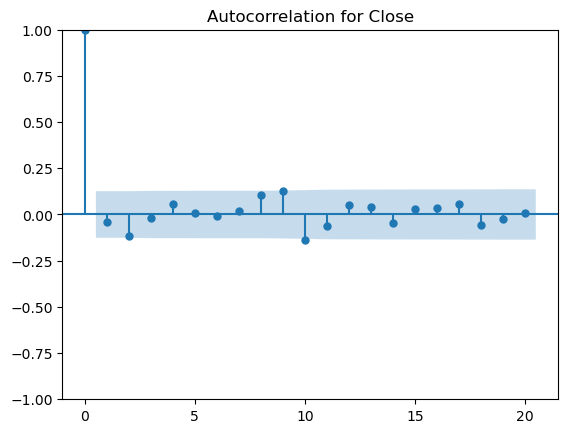

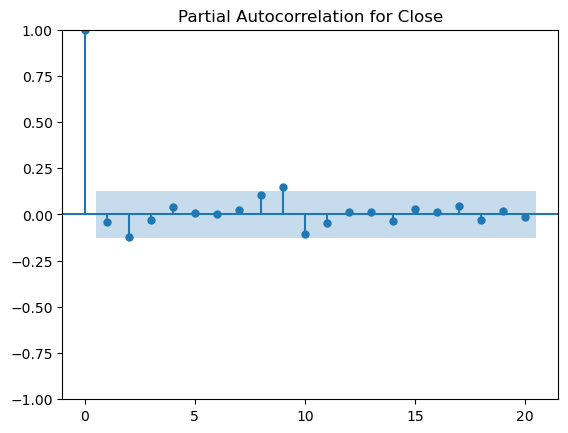

In [14]:
plot_autocorrelograms(diff_data,'Close')

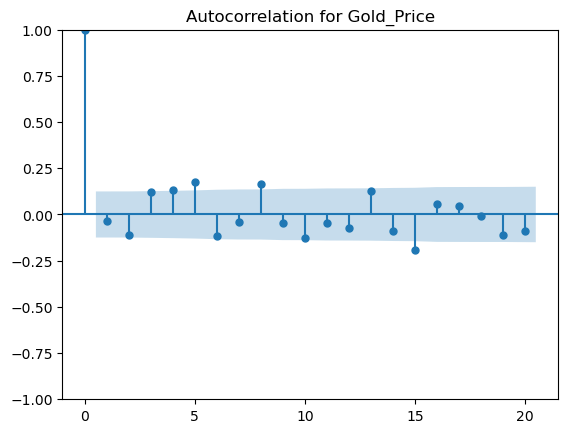

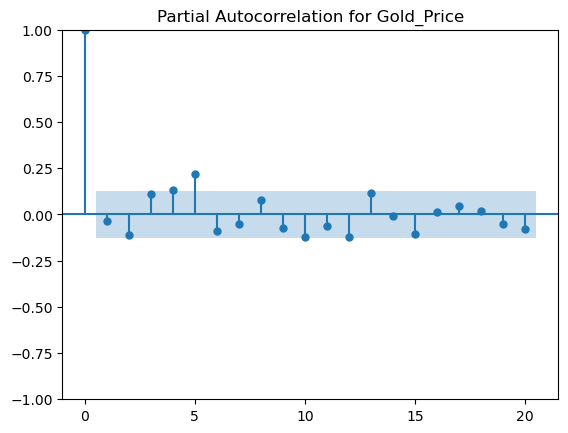

In [46]:
plot_autocorrelograms(diff_data,'Gold_Price')

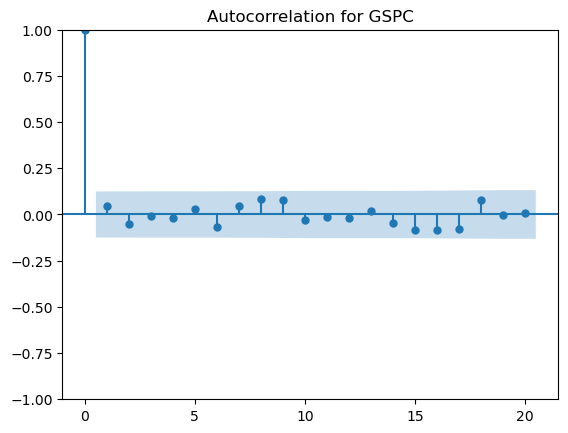

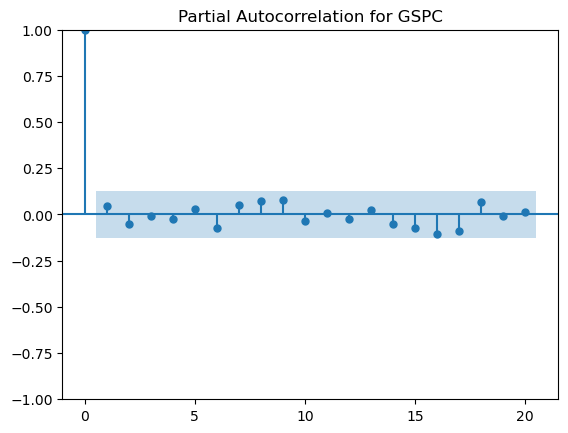

In [47]:
plot_autocorrelograms(diff_data,'GSPC')

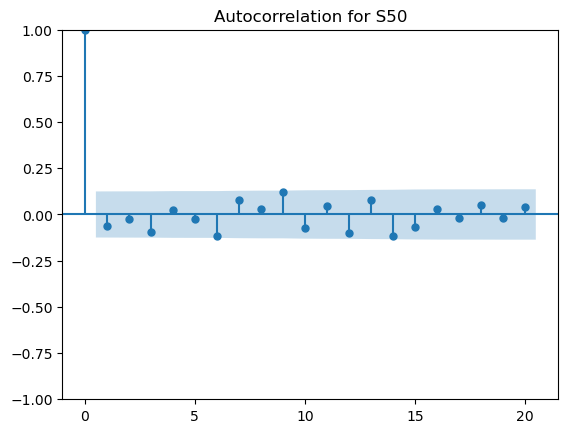

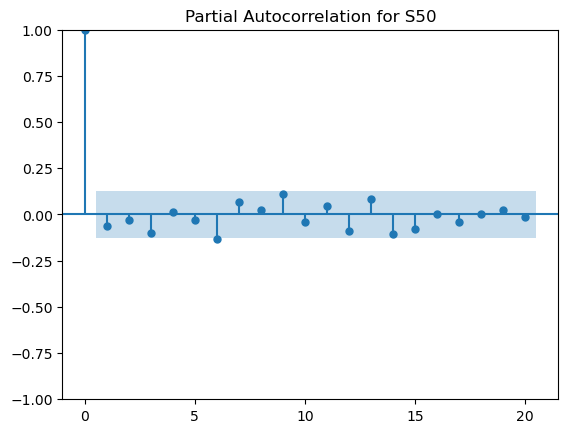

In [48]:
plot_autocorrelograms(diff_data,'S50')

# Model Training

In [11]:
data = usd_eur.copy()
df = data.dropna()

train, test = df[:-5], df[-5:]

data = train[['Close','Gold_Price','S50','GSPC']]

diff_data = diff(data, k_diff=1)
diff_test = diff(df[-6:], k_diff=1)

p = np.arange(1,11)
q = np.arange(1,11)
models = []
orders = []
MSEs = []
for i in p:
    for j in q:
        orders.append((i,j))
        model = VARMAX(endog=diff_data[['Close','Gold_Price']], order=(i,j), mle_regression = True, filter_concentrated = True, initialization='approximate_diffuse', exog=diff_data[['S50','GSPC']])
        model_fit = model.fit(disp=False)
        pred = pd.DataFrame()
        pred['prediction'] = data.iloc[-1]['Close'] + np.cumsum(model_fit.forecast(5, exog=diff_test[['S50','GSPC']]).reset_index(drop=True).Close)
        pred['observed'] = test.reset_index(drop=True).Close
        models.append(model_fit)
        MSEs.append(np.mean((pred['prediction'].values-pred['observed'].values)**2))

/Users/amaankazi/miniconda3/envs/mlsp/lib/python3.11/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/Users/amaankazi/miniconda3/envs/mlsp/lib/python3.11/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/Users/amaankazi/miniconda3/envs/mlsp/lib/python3.11/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/Users/amaankazi/miniconda3/envs/mlsp/lib/python3.11/site-packages/statsmodels/tsa/statespace/varmax.py:161: Est

In [12]:
idx = np.argmin(MSEs)
print(orders[idx])
model_fit = models[idx]

(6, 10)


/Users/amaankazi/miniconda3/envs/mlsp/lib/python3.11/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/Users/amaankazi/miniconda3/envs/mlsp/lib/python3.11/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'


Text(0.5, 1.0, 'MSE = 8.062692315248498e-06')

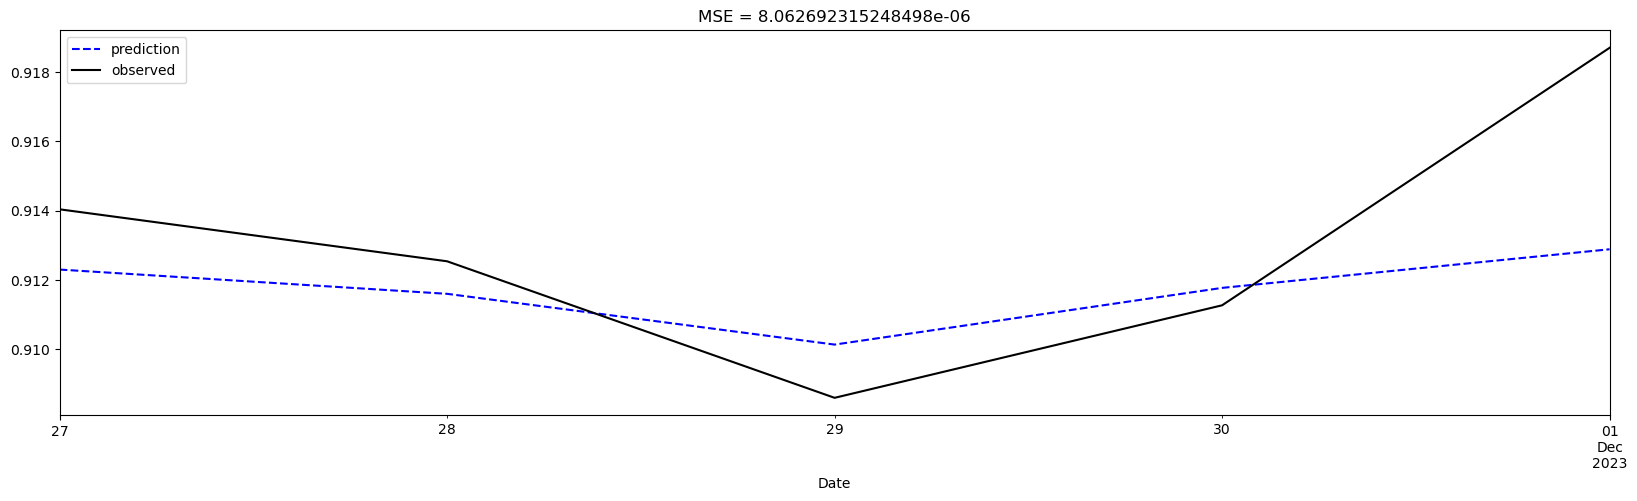

In [42]:
# plot prediction vs observed
pred = pd.DataFrame()
pred['prediction'] = data.iloc[-1]['Close'] + np.cumsum(model_fit.forecast(5, exog=diff_test[['S50','GSPC']]).reset_index(drop=True).Close)
pred['observed'] = test.reset_index(drop=True).Close
pred['Date'] = test['Date'].reset_index(drop=True)

pred.plot(figsize=(20,5),title='prediction vs observed',color=['blue','black'],style=['--','-'], x='Date')
plt.title(f"MSE = {np.mean((pred['prediction'].values-pred['observed'].values)**2)}")

In [43]:
print(pred)

   prediction  observed       Date
0    0.912301   0.91404 2023-11-27
1    0.911601   0.91254 2023-11-28
2    0.910136   0.90860 2023-11-29
3    0.911773   0.91127 2023-11-30
4    0.912887   0.91870 2023-12-01


In [45]:
# Train all the data using the best p and q parameters
diff_data_all = diff(usd_eur[['Close','Gold_Price','S50','GSPC']], k_diff=1)
model = VARMAX(endog=diff_data_all[['Close','Gold_Price']], order=orders[idx], mle_regression = True, filter_concentrated = True, initialization='approximate_diffuse', exog=diff_data_all[['S50','GSPC']])
model_fit_final = model.fit(disp=False)

/Users/amaankazi/miniconda3/envs/mlsp/lib/python3.11/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'


In [46]:
forecast_vals = usd_eur.iloc[-1]['Close'] + np.cumsum(model_fit_final.forecast(5, exog=diff_test[['S50','GSPC']]).reset_index(drop=True).Close)
print(forecast_vals)

0    0.911146
1    0.908819
2    0.910826
3    0.909617
4    0.908355
Name: Close, dtype: float64


/Users/amaankazi/miniconda3/envs/mlsp/lib/python3.11/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/Users/amaankazi/miniconda3/envs/mlsp/lib/python3.11/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'


In [47]:
forecast_vals.values.tofile("./predictions_usdeur.csv", sep=',')

In [16]:
import pickle
pickle.dump(model_fit, open(f"./usd_eur_models/model_{orders[idx][0]}_{orders[idx][1]}_best.pkl","wb"))